In [1]:
!pip install --upgrade google-cloud
!pip install --upgrade google-cloud-bigquery
!pip install --upgrade google-cloud-storage
!pip install db-dtypes
!pip install 'google-cloud-bigquery[pandas]'
!pip install numpy
!pip install pandas
!pip install google.cloud
!pip install scipy
!pip install plotly
!pip install seaborn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip



In [20]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes

def test(start_date, end_date,entity_d):

    query = f"""
            select  session_key
                    ,(case when sum(case when eventAction = 'shop.clicked' then 1 else 0 end) > 0 Then 1 else 0 end) as vendor_page_opened
                    ,(case when sum(case when eventAction = 'transaction' then 1 else 0 end) > 0 Then 1 else 0 end) as transacted
                    ,AVG(
    ROUND(
        COALESCE(
            CAST(
                NULLIF(
                    REGEXP_EXTRACT(
                        COALESCE(
                            json_value(eventVariables_json, "$.vendorDeliveryFee"),
                            json_value(eventVariables_json, "$.shopDeliveryFee")
                        ), 
                        r'([0-9]+\.?[0-9]*)'
                    ), 
                    ''
                ) AS FLOAT64
            ),
            0
        ),
    2)
) AS delivery_fee
            FROM `fulfillment-dwh-production.curated_data_shared_coredata_tracking.perseus_events`
            WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"
                    AND global_entity_id = 'MJM_AT'
                    --AND session_key = "SlXTIyTYecRbys2s4lOZUA=="
            group by 1
        """
    
    return query



<>:36: SyntaxWarning: invalid escape sequence '\.'
<>:36: SyntaxWarning: invalid escape sequence '\.'
/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_43414/3920311812.py:36: SyntaxWarning: invalid escape sequence '\.'
  WHERE partition_date BETWEEN \"""" + start_date + """\" and \"""" + end_date + """\"


In [21]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

start_date = '2024-06-01'
end_date = '2024-06-07'

# entity_id = 'DJ_CZ','FO_NO','MJM_AT','NP_HU','OP_SE','PO_FI','YS_TR','EF_GR','FY_CY','FP_BD','FP_HK','FP_KH','FP_LA','FP_MM','FP_MY','FP_PH','FP_PK','FP_SG','FP_TH','FP_TW','HS_SA','AP_PA','PY_AR','PY_BO','PY_CL','PY_CR','PY_DO','PY_EC','PY_GT','PY_HN','PY_NI','PY_PE','PY_PY','PY_SV','PY_UY','PY_VE','HF_EG','TB_AE',
# 'TB_BH','TB_IQ','TB_JO','TB_KW','TB_OM','TB_QA'

entity_id = 'MJM_AT'
entity_id_str = ",".join([f"'{entity}'" for entity in entity_id])

match_details_df = client.query(test(start_date, end_date,entity_id_str)).to_dataframe()

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,session_key,vendor_page_opened,transacted,delivery_fee,delivery_fee_rounded
0,OHNiOkzCwcZ5AN1M0p7PfQ==,0,0,0.000000,0.00
1,JLYbOGuAAxkewCEF14XgHg==,0,1,0.060166,0.06
2,Af8HN5ptllfdEcTcylZKug==,0,1,0.268590,0.27
3,3xDmbYuCxY6gZrXzki98Wg==,0,0,1.727755,1.73
4,yIZ/GKi873Xl3BppVNuEOQ==,0,1,0.197143,0.20
...,...,...,...,...,...
1085347,iZwXmNhj3BQ3UtaAyEvnfw==,1,1,0.000000,0.00
1085348,Zk3og/2699VlOSQeVXektA==,1,0,0.045825,0.05
1085349,wssw9zT1dB80+kjYSuw9bg==,1,0,0.031923,0.03
1085350,Y3sfnfaNBk82/zF7ILhrLg==,1,0,0.236871,0.24


count    1.085352e+06
mean     2.957385e-01
std      6.135194e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.100000e-01
max      6.990000e+00
Name: delivery_fee_rounded, dtype: float64

<Axes: xlabel='delivery_fee_rounded'>

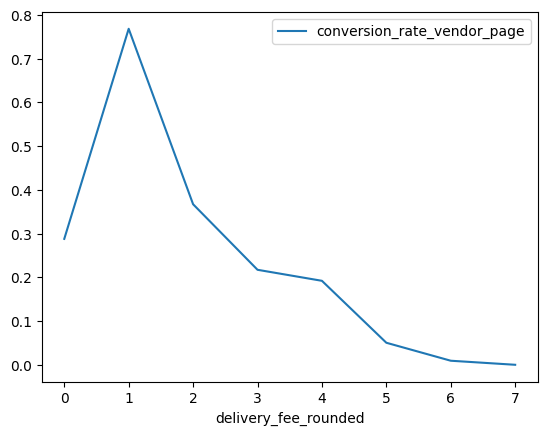

In [38]:
match_details_df['delivery_fee_rounded'] = match_details_df['delivery_fee'].round(0)
match_details_df

# Group by 'Group'
grouped = match_details_df.groupby('delivery_fee_rounded')

# Count the number of rows with value 1 in 'Value' column for each group
count_ones_v = grouped['vendor_page_opened'].apply(lambda x: (x == 1).sum())
count_ones_o = grouped['transacted'].apply(lambda x: (x == 1).sum())

# Count the total number of rows for each group
total_counts = grouped.size()

# Combine counts into a single DataFrame
result = pd.DataFrame({
    'converted_vendors': count_ones_v,
    'converted_orders': count_ones_o,
    'total_sessions': total_counts
}).reset_index()

result['conversion_rate_vendor_page'] = result['converted_vendors']/result['total_sessions']
result['conversion_rate_orders'] = result['converted_orders']/result['total_sessions']


result.plot(x = 'delivery_fee_rounded',y = 'conversion_rate_vendor_page')

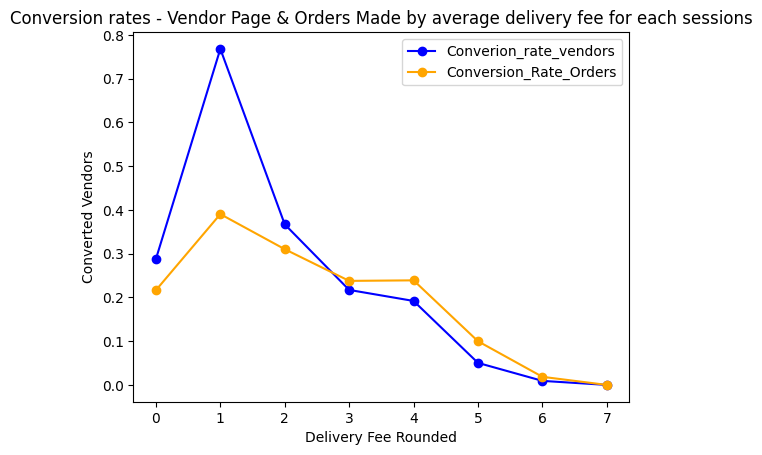

In [44]:
# Create the plot
ax = result.plot(x='delivery_fee_rounded', y='conversion_rate_vendor_page', label='Converion_rate_vendors', marker='o', color='blue')

# Plot the normalized conversion rate orders on the same axis
result.plot(x='delivery_fee_rounded', y='conversion_rate_orders', label='Conversion_Rate_Orders', marker='o', color='orange', ax=ax)

# Add labels and title
ax.set_xlabel('Delivery Fee Rounded')
ax.set_ylabel('Converted Vendors')
plt.title('Conversion rates - Vendor Page & Orders Made by average delivery fee for each sessions')

# Add a legend to distinguish between the two lines
plt.legend()

# Show the plot
plt.show()